# Heat equation experiments with neural networks

In [713]:
# Configuration
method = 'adams' # 'adams'
data_size = 1000
batch_time = 10
batch_size = 20
niters = 2000
test_freq = 20
viz = True
gpu = 0
adjoint = True

In [714]:
# Import packages
import os
import argparse
import time
import numpy as np
import pylab as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import grad
import matplotlib.pyplot as plt

if adjoint:
    from torchdiffeq import odeint_adjoint as odeint
else:
    from torchdiffeq import odeint

---
# Pytorch - PINN to determine U
---

### Analytical solution

Analytical solution (used for generation of training data)

In [53]:
def simple_plotter(ks, title='Simple plot'):
    """
    Graphic tool to plot simple values
    """
    fig, ax = plt.subplots()
    fig.tight_layout()
    plt.title(title)
    for k in ks:
        ax.plot(range(len(k)), k)
    
    plt.show()

In [54]:
def analytical_heat_1d(t, x, n_max: int=1):
    """
    Analytical solution to 1D heat equation.
    Return solution for a tuple (t, x)
    """
    return np.sum([np.exp(-np.pi**2 * n**2 * t) * np.sin(n * np.pi * x) for n in range(n_max)], axis=0)

In [55]:
def analytical_grad_t_heat_1d_t(t, x, n_max: int=1):
    """
    Analytical gradient by t of the solution to 1D heat equation
    Return value for a tuple (t, x)
    """
    return np.sum([-np.pi**2 * n**2 * np.exp(-np.pi**2 * n**2 * t) * np.sin(n * np.pi * x) for n in range(n_max)], axis=0)

In [56]:
def get_heat(t_max, t_min, x_max, x_min, t_n, x_n):
    """
    Compute heat equation solution values for a set of (t, x) tuples.
    """
    t_axis = np.linspace(t_min, t_max, t_n)
    x_axis = np.linspace(x_min, x_max, x_n)
    
    return analytical_heat_1d(t_axis[:, None], x_axis[None, :], 10)

In [57]:
def get_heat_grad_t(t_max, t_min, x_max, x_min, t_n, x_n):
    """
    Compute gradient by t to heat equation solution values for a set of (t, x) tuples.
    """
    t_axis = np.linspace(t_min, t_max, t_n)
    x_axis = np.linspace(x_min, x_max, x_n)
    
    return analytical_grad_t_heat_1d_t(t_axis[:, None], x_axis[None, :], 10)

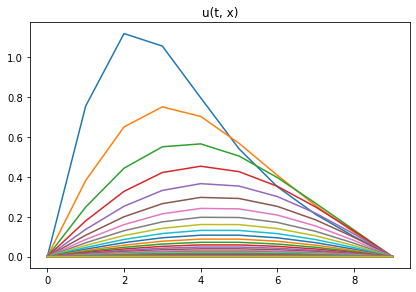

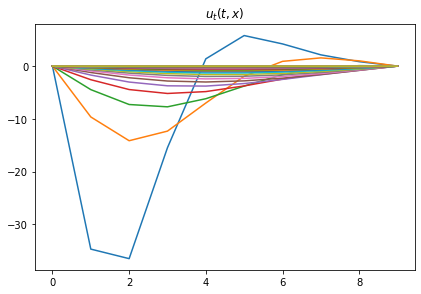

In [59]:
u_true = get_heat(1, 0, 1, 0, 50, 10)
u_t_true = get_heat_grad_t(1, 0, 1, 0, 50, 10)
#print(u_true.shape)
simple_plotter(u_true[1:], 'u(t, x)')
simple_plotter(u_t_true[1:], r'$u_{t}(t, x)$')

---
### Data processing

Perform data processing, and generate batch for the training

In [9]:
def data_processing(t_n=100, x_n=100, batch_size=10, x_tu=(0.0, 1.0), t_tu=(0.0, 1.0)):
    """
    Generate a data-set of solution to heat equation for different tuples (t, x).
    Return boundary tuples (t, x, u) and inner space tuples (t, x, u).
    """
    # Discrete points
    
    # X 1d-space discretiztion
    x_min, x_max = x_tu[0], x_tu[1]
    x_range = np.linspace(x_min, x_max, x_n)
    
    # T 1d-time discretization
    t_min, t_max = t_tu[0], t_tu[1]
    t_range = np.linspace(t_min, t_max, t_n)
    
    # True solution
    u_true = get_heat(t_max, t_min, x_max, x_min, t_n, x_n) # u_true dim = (T, X)
    
    # Conversion
    x_axis = torch.from_numpy(x_range).float().reshape(int(x_n / batch_size), batch_size, 1)
    x_axis.requires_grad = True
    
    t_axis = torch.from_numpy(t_range).float().reshape(t_n, 1)
    t_axis_batch = t_axis.reshape(int(t_n / batch_size), batch_size, 1)
    t_axis_batch.requires_grad = True
    
    data_bound = boundary_data_zero(t_n, x_n, batch_size, t_axis_batch, x_axis, x_min, x_max, u_true)
    data_in = domain_data_zero(t_n, x_n, batch_size, x_axis, t_axis)
    
    return data_bound, data_in

In [10]:
def boundary_data_zero(t_n, x_n, batch_size, t_axis, x_axis, x_min, x_max, u_true):
    # Generate boundaries data
    # Specify the boundaries values for tuples generation
    
    # T = 0
    bound_t0 = torch.zeros(x_n, dtype=torch.float, requires_grad=True).reshape(int(x_n / batch_size), batch_size, 1)
    # U values for T = 0
    bound_u_t0 = torch.from_numpy(u_true[0, :]).float().reshape(int(x_n / batch_size), batch_size, 1)
    
    
    # X = x_min (=0)
    bound_x0  = torch.zeros(t_n, dtype=torch.float, requires_grad=True).reshape(int(t_n / batch_size), batch_size, 1)# + x_min
    # U values for X = 0
    # bound_u_x0 = torch.from_numpy(u_true[:, 0]).float().reshape(int(t_n / batch_size), batch_size, 1)
    bound_u_x0 = torch.zeros(t_n, dtype=torch.float, requires_grad=True).reshape(int(t_n / batch_size), batch_size, 1) 
    
    # X = x_max (=1)
    bound_x1 = torch.zeros(t_n, dtype=torch.float, requires_grad=True).reshape(int(t_n / batch_size), batch_size, 1) + x_max
    # U values for X = 1
    # bound_u_x1  = torch.from_numpy(u_true[:, x_n-1]).float().reshape(int(t_n / batch_size), batch_size, 1)
    bound_u_x1  = torch.zeros(t_n, dtype=torch.float, requires_grad=True).reshape(int(t_n / batch_size), batch_size, 1)
    
    # Tuples
    m1 = list(zip(x_axis, bound_t0, bound_u_t0))
    m2 = list(zip(bound_x0, t_axis, bound_u_x0))
    m3 = list(zip(bound_x1, t_axis, bound_u_x1))
     
    # Boundary tuples (x, y, u)
    # data_bound = m1 + m2 + m3
    data_bound = m1 + m2 + m3
    perm = np.random.permutation(len(data_bound))
    
    return [data_bound[p] for p in perm]

In [11]:
def domain_data_zero(t_n, x_n, batch_size, x_axis, t_axis):
    # Generate domain data. We want f(u) = du/dt - k * d2u/dx2 = 0
    data_in = []
    zeros  = torch.zeros(batch_size, dtype=torch.float, requires_grad=True).reshape(1, batch_size, 1)
    # def_in = zeros[0].reshape(1, batch_size, 1)
    def_in = zeros.clone()
    
    for i in range(t_n):
        t_in = zeros.clone()
        t_in[:][:] = t_axis[i] # Set t batch value
        for j in range(int(x_n / batch_size)):        
            x_in = x_axis[j].reshape(1, batch_size, 1) # (batch_size, 1) to (1, batch_size, 1)
            # t_in = ts[0].reshape(1, batch_size, 1) # 
            data_in.append(list(zip(x_in, t_in, def_in)))
    
    perm = np.random.permutation(len(data_in))
    
    return [data_in[p] for p in perm]

### Heat neural network

In [12]:
class HeatPDE(nn.Module):
    """
    Neural network to determine heat equation solution
    """
    def __init__(self):
        super(HeatPDE, self).__init__()
        self.inl = nn.Linear(2, 50) # 2,80
        self.ml1 = nn.Linear(50, 20) #80,50
        self.ou = nn.Linear(20, 1) #50,1
        self.tn = nn.Tanh()

    def forward(self, t, x):
        u = torch.cat((t, x), 1)
        hid1 = self.inl(u)
        hid2 = self.ml1(self.tn(hid1))
        out = self.ou(self.tn(hid2))
        
        return out

### Heat equation integrating to neural network

In [13]:
def flat(x):
    m = x.shape[0]
    return [x[i] for i in range(m)]

def gradient(f, wrt, n):
    """
    Computes and returns the sum of gradients of outputs with respect to the inputs.
    """
    for i in range(n):
        grads = grad(flat(f), wrt, create_graph=True, allow_unused=True)[0]
        f = grads
        if grads is None:
            return torch.tensor(0.)
    
    return grads

def f_func(t, x, net):
    u = net(t, x)
    u_t = gradient(u, t, 1)
    u_x = gradient(u, x, 1)
    u_xx = gradient(u, x, 2)
    k = torch.tensor(1)
    f = u_t - k * u_xx
    return f

### Training

In [14]:
def training_heat_net(net, epochs=1000, t_n=100, x_n=100, batch_size=10):  
    batch_bound, batch_insi = data_processing(t_n, x_n, batch_size, (0.0, 1.0), (0.0, 1.0))
    loss_fn = nn.MSELoss()
    
    optimizer = optim.SGD(net.parameters(), lr=0.005)
    
    for e in range(1, epochs + 1):
        loss1_tot = 0
        loss2_tot = 0
        for i in range(len(batch_bound)):
            ran_b = batch_bound[i]
            ran_i = batch_insi[i]
            
            optimizer.zero_grad()
            
            outputs = net(ran_b[1], ran_b[0]) # Boundaries use neural network
            outputs_f = f_func(ran_i[0][1], ran_i[0][0], net) # Inside use net + grad
            
            loss1 = loss_fn(outputs, ran_b[2])
            loss2 = loss_fn(outputs_f, ran_i[0][2])
            
            loss1_tot += loss1.item()
            loss2_tot += loss2

            loss_tot = loss1 + loss2
            loss_tot.backward(retain_graph=True)
            optimizer.step()
        
        if e % 500 == 0:
            print('epoch %d boundary loss %f, f loss %f'%(e, float(loss1_tot), float(loss2_tot)))
            
            
    return net

---
### Evaluate results

In [16]:
def show_state(a, title): 
    fig, axes = plt.subplots(1, 1, figsize=(16, 5))
    im = axes.imshow(a, origin='upper', cmap='inferno')
    plt.colorbar(im); 
    plt.xlabel('x'); 
    plt.ylabel('t'); 
    plt.title(title)

Parameters

In [17]:
t_min = 0
x_min = 0
t_max = 1
x_max = 1
t_n = 20
x_n = 50
epochs = 5000

Visualize uninitialized neural network heatmap values

In [502]:
t_axis = np.linspace(t_min, t_max, t_n)
x_axis = np.linspace(x_min, x_max, x_n)
grid_xt = np.meshgrid(x_axis, t_axis, indexing='xy')
grid_x, grid_t = [torch.from_numpy(t).float() for t in grid_xt]

grid_t = torch.unsqueeze(grid_t, dim=-1)
grid_x = torch.unsqueeze(grid_x, dim=-1)

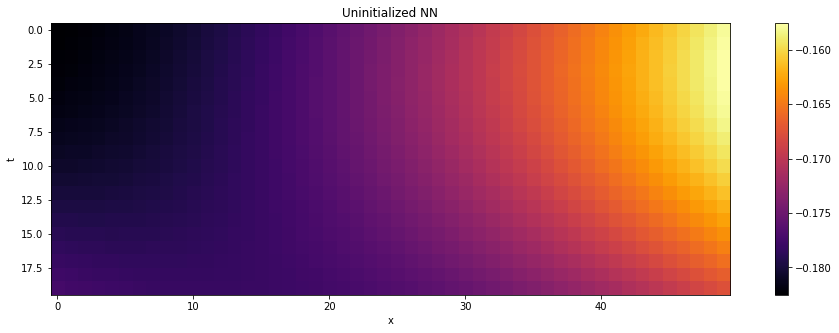

In [19]:
net = HeatPDE()

u_m = np.zeros((t_n, x_n, 1))
for i in range(t_n):
    u_m[i] = net(grid_t[i], grid_x[i]).detach().numpy()

show_state(u_m, 'Uninitialized NN')

In [20]:
heat_model2 = training_heat_net(net, epochs, t_n, x_n, 10)

epoch 500 boundary loss 0.751477, f loss 0.026837
epoch 1000 boundary loss 0.653884, f loss 0.013892
epoch 1500 boundary loss 0.546388, f loss 0.016447
epoch 2000 boundary loss 0.472713, f loss 0.032880
epoch 2500 boundary loss 0.410092, f loss 0.038287
epoch 3000 boundary loss 0.326341, f loss 0.035556
epoch 3500 boundary loss 0.204328, f loss 0.037092
epoch 4000 boundary loss 0.098731, f loss 0.042344
epoch 4500 boundary loss 0.051238, f loss 0.034624
epoch 5000 boundary loss 0.058086, f loss 0.043762


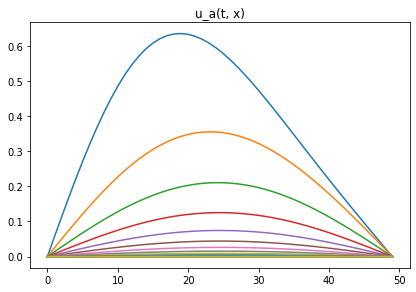

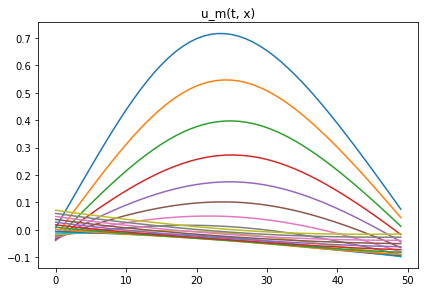

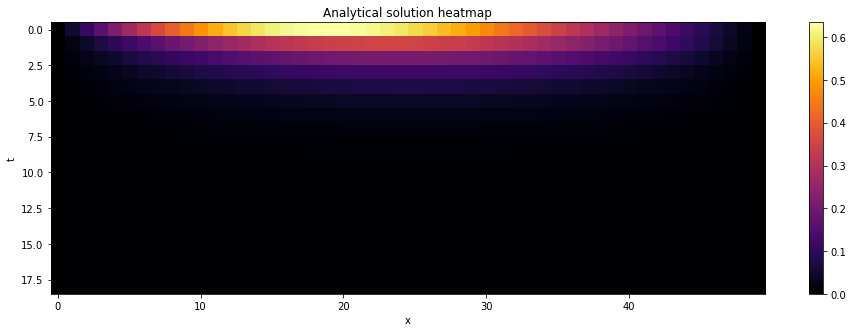

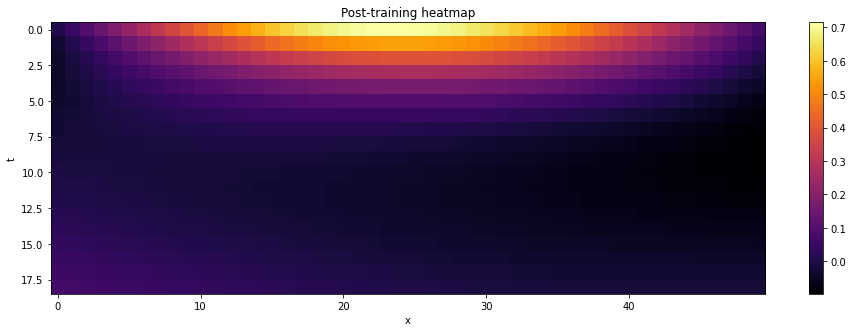

In [21]:
def visualize_all(net, u_a, t_axis, x_axis, grid_t, grid_x, plotter=True, heatmap=False):
    # u_a = analytical_heat_1d(t_axis[:, None], x_axis[None, :], 100)
    u_m2 = np.zeros((t_n, x_n, 1))

    for i in range(t_n):
        u_m2[i] = net(grid_t[i], grid_x[i]).detach().numpy()

    if plotter:
        simple_plotter(u_a[1:], 'u_a(t, x)')
        simple_plotter(u_m2[1:], 'u_m(t, x)')

    if heatmap:
        show_state(u_a[1:], 'Analytical solution heatmap')
        show_state(u_m2[1:], 'Post-training heatmap')

u_a = analytical_heat_1d(t_axis[:, None], x_axis[None, :], 100)
visualize_all(heat_model2, u_a, t_axis, x_axis, grid_t, grid_x, True, True)

tensor([0.0526])


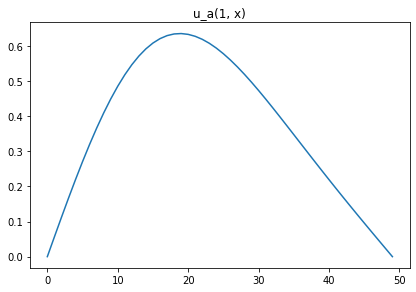

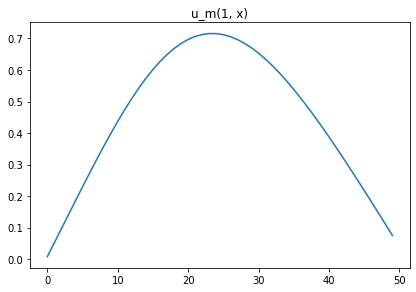

In [22]:
def visualize_single():
    u_a = analytical_heat_1d(0.0526, x_axis[None, :], 100)
    u_m = heat_model2(grid_t[1], grid_x[1]).detach().numpy()
   
    print(grid_t[1][0])
    simple_plotter(u_a, 'u_a(1, x)')
    simple_plotter([u_m], 'u_m(1, x)')
        
visualize_single()

---
# Determine F on paper
---

Considering the linear relation $Ax = b$, we can determine the operator F by setting $A = U$, $x = F$ and $b = U_t$. Thus, let's set:
$A x = b$

$U F = U_{t}$

$U^{T} F^{T} = U_{t}^{T}$

$U U^{T} F^{T} = U U_{t}^{T}$

$F^{T} = (U U^{T})^{-1} U_{t}^{T}$

$F = U_{t} U^{T} (U U^{T})^{-T}$

With regularization term:

$F = U_{t} U^{T} (U U^{T} + \Gamma \Gamma^{T})^{-1}$

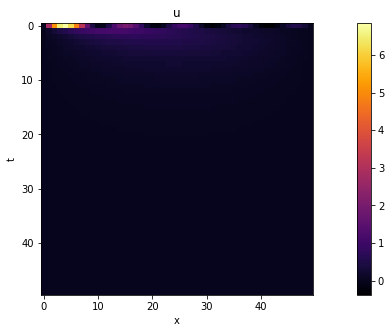

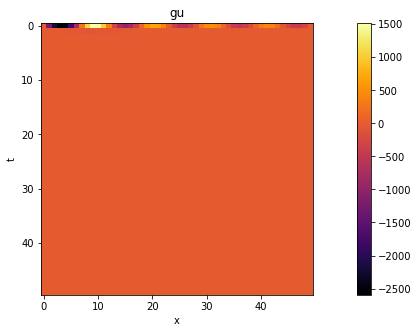

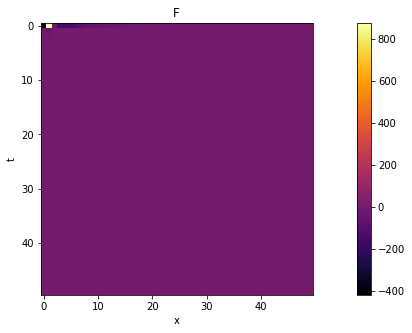

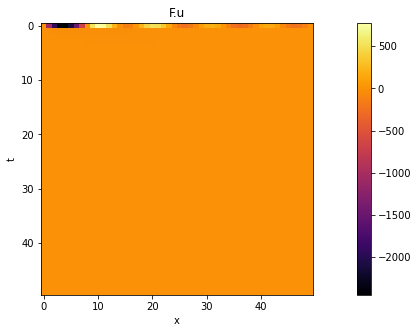

In [744]:
def get_F_handy(t_max, t_min, x_max, x_min, t_n, x_n):
    u = get_heat(t_max, t_min, x_max, x_min, t_n, x_n)
    g_u = get_heat_grad_t(t_max, t_min, x_max, x_min, t_n, x_n)
    tmp = np.matmul(g_u, u.T)
    tmp2 = np.matmul(u, u.T)
    tmp3 = np.matmul(np.identity(50), np.identity(50).T) # regularization
    tmp4 = np.linalg.pinv(tmp2 + tmp3)
    F = np.matmul(tmp, tmp4)
    return F

u = get_heat(1.0, 0.0, 1.0, 0.0, 50, 50)
g_u = get_heat_grad_t(1.0, 0.0, 1.0, 0.0, 50, 50)
F = get_F_handy(1.0, 0.0, 1.0, 0.0, 50, 50)
show_state(u, 'u')
show_state(g_u, 'gu')
show_state(F, 'F')

test = np.matmul(F, u)
show_state(test, 'F.u')

---
# Pytorch - Neural ODE to determine F0
---

1 - Generate a U snapshot.
- Try to obtain U gradient from its snapshots (not working)
- Enforce model and generate snapshot from U snapshot.

In [72]:
def snapshot_data_u(t_n, x_n, t_tu, x_tu, batch_size, process=lambda x: x):
    """
    Generate snapshot for solution to heat equation
    """
    # X 1d-space discretization
    x_min, x_max = x_tu[0], x_tu[1]
    x_range = np.linspace(x_min, x_max, x_n)
    
    # T 1d-time discretization
    t_min, t_max = t_tu[0], t_tu[1]
    t_range = np.linspace(t_min, t_max, t_n)
    
    # True solution
    u = get_heat(t_max, t_min, x_max, x_min, t_n, x_n) # u dim = (T, X)
    #f_u = process(u)
    grad_u = get_heat_grad_t(t_max, t_min, x_max, x_min, t_n, x_n)
    
    # Conversion
    x_axis = torch.from_numpy(x_range).float().reshape(int(x_n / batch_size), batch_size, 1)
    x_axis.requires_grad = True
    
    t_axis = torch.from_numpy(t_range).float().reshape(t_n, 1)
    t_axis_batch = t_axis.reshape(int(t_n / batch_size), batch_size, 1)
    t_axis_batch.requires_grad = True
    
    # Snapshot
    snapshot = get_snapshot_enforced_model(u, grad_u, t_axis, x_axis, t_n, x_n, batch_size, process)

    return snapshot

In [73]:
def get_snapshot_enforced_model(u, g_u, t_axis, x_axis, t_n, x_n, batch_size, process=lambda x: x):
    """
    Generate tuples for inner domain 
    """
    # Snapshot
    snapshot = []
    zeros  = torch.zeros(batch_size, dtype=torch.float, requires_grad=True).reshape(1, batch_size, 1)
    
    for i in range(t_n):
        t_in = zeros.clone()
        t_in[:][:] = t_axis[i] # Set t batch value
        u_in = u[i].reshape(int(x_n / batch_size), batch_size, 1)
        g_u_in = g_u[i].reshape(int(x_n / batch_size), batch_size, 1)
        
        for j in range(int(x_n / batch_size)):  
            x_in = x_axis[j].reshape(1, batch_size, 1) # (batch_size, 1) to (1, batch_size, 1)
            u2 = torch.from_numpy(u_in[j]).float().reshape(1, batch_size, 1)
            g_u2 = torch.from_numpy(g_u_in[j]).float().reshape(1, batch_size, 1)
            snapshot.append(list(zip(x_in, t_in, u2, g_u2)))  # Incorrect, on utilise u au lieu de grad u
    
    return snapshot

2 - Enforce a model for $F_{\theta} = A$.
From the knowledge of the heat equation, we can manually generate a snapshot of the operator composed of a single linear matrix A and a snapshot matrix $u_\theta$

In [74]:
def get_A(X):
    a = np.zeros((X, X))
    d = 1 / (X - 1)
    for i in range(X):
        a[i][i] = -2
        
    for i in range(X-1):
        a[i][i+1] = 1
        a[i+1][i] = 1
        
    A = a * (1. / d**2)
    
    return A

In [75]:
def snapshot_data_f(t_n, x_n, t_tu, x_tu, batch_size):
    A = get_A(x_n)
    process = lambda x : np.matmul(x, A)
    f_snapshot = snapshot_data_u(t_n, x_n, t_tu, x_tu, batch_size, process)
    
    return f_snapshot

In [76]:
f_snapshot = snapshot_data_f(t_n, x_n, (0.0, 1.0), (0.0, 1.0), 10)

### Heat neural network 2

In [77]:
class HeatPDE_2(nn.Module):
    def __init__(self):
        super(HeatPDE_2, self).__init__()
        self.inl = nn.Linear(1, 50)
        self.ml1 = nn.Linear(50, 50)
        self.ou = nn.Linear(50, 1)
        self.tn = nn.Tanh()

    def forward(self, u):
        inp = u # torch.cat((t, x, u), 1)
        hid1 = self.inl(inp)
        hid2 = self.ml1(self.tn(hid1))
        out = self.ou(self.tn(hid2))
        return out

### Training 2 - Train NN to determine F

Previously we implemented a simple PINN to determine $u_\theta$ from a batch of boundary condition, initial condition $u_0 = u(0,x)$ and the known heat-equation.
In reality we don't want to determine $u$; we are interested by the closure model $\frac{\partial u}{\partial t} = F_{\theta}(u)$.

So, we adapt our neural network.

In [82]:
def training_heat_model_net(net, epochs=1000, t_n=100, x_n=100, batch_size=10):  
    batch_insi = snapshot_data_f(t_n, x_n, (0.0, 1.0), (0.0, 1.0), batch_size)
    loss_fn = nn.MSELoss()
    optimizer = optim.SGD(net.parameters(), lr=0.005)
    
    for e in range(1, epochs + 1):
        loss_tot = 0
        for i in range(len(batch_insi)):
            optimizer.zero_grad()
            
            ran_i = batch_insi[i]
            outputs_f = net(ran_i[0][2]) # Inside use net + grad
            loss = loss_fn(outputs_f, ran_i[0][3])
            loss_tot += loss.item()
            
            loss.backward(retain_graph=True)
            optimizer.step()
        
        if e % 100 == 0:
            print('epoch %d, f loss %f'%(e, float(loss_tot)))
    
    return net

In [83]:
epochs2 = 100
t_n2 = 20
x_n2 = 50

In [84]:
net2 = HeatPDE_2()
f_model = training_heat_model_net(net2, epochs2, t_n2, x_n2, 10)

epoch 100, f loss 3905190.855346


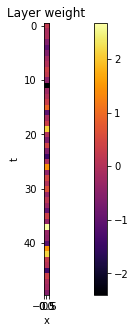

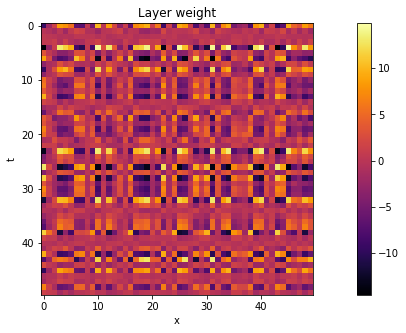

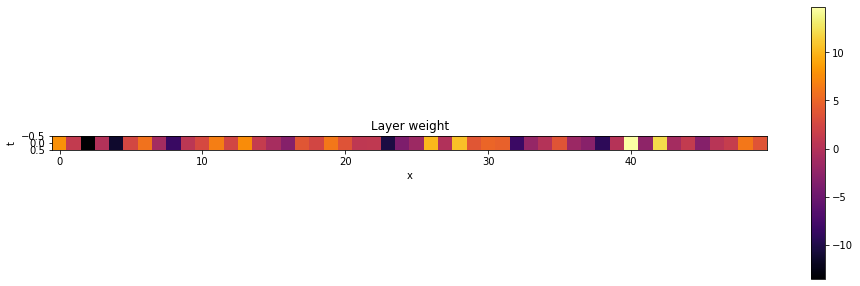

In [85]:
for name, param in net2.named_parameters():
    if 'weight' in name:
        weights = param.detach().numpy()
        show_state(weights, 'Layer weight')

---
# torchdiffeq
---

### Heat equation

Definition of expected results from Heat equation.

In [596]:
def ode_data_processing(t_n, x_n, t_tu, x_tu, batch_size=(10,10), process=lambda x: x):
    """
    Generate snapshot for solution to heat equation
    """
    
    # Get batch size
    (t_batch_size, x_batch_size) = batch_size
    
    # X 1d-space discretization
    x_min, x_max = x_tu[0], x_tu[1]
    x_range = np.linspace(x_min, x_max, x_n)
    
    # T 1d-time discretization
    t_min, t_max = t_tu[0], t_tu[1]
    t_range = np.linspace(t_min, t_max, t_n)
    
    # True solution
    u = get_heat(t_max, t_min, x_max, x_min, t_n, x_n) # u dim = (T, X)
    u0 = u[0, :]
    u_true = u[1:, :]
    
    # Conversion
    x_axis = torch.from_numpy(x_range).float().reshape(int(x_n / x_batch_size), x_batch_size, 1)
    # x_axis.requires_grad = True
    
    t_axis = torch.from_numpy(t_range).float().reshape(t_n, 1)
    t_axis_batch = t_axis.reshape(int(t_n / t_batch_size), t_batch_size, 1)
    # t_axis_batch.requires_grad = True
    
    # Snapshot
    bt, b0, by = get_snapshot_ode_solver_model(u0, u_true, t_axis, x_axis, t_n, x_n, batch_size)

    # return snapshot
    return bt, b0, by

In [647]:
def get_snapshot_ode_solver_model(u0_true, u_true, t_axis, x_axis, t_n, x_n, batch_size):
    """
    Generate tuples for inner domain 
    """
    # Get batch size
    (t_batch_size, x_batch_size) = batch_size
    
    bt = t_axis.reshape(int(t_n / t_batch_size), t_batch_size).clone()
    tmp_u0 = u0_true.reshape(int(x_n / x_batch_size), x_batch_size, 1)
    bu0 = torch.from_numpy(tmp_u0).float().clone()
    b0 = torch.cat((x_axis, bu0), 2).reshape(int(x_n / x_batch_size), x_batch_size, 1, 2).clone()
    
    bx = x_axis.repeat(t_batch_size, 1, 1, 1).clone()
    by = []
    
    for i in range(int((t_n - 1) / t_batch_size)):
        tmp_u = u_true[i:i+t_batch_size].reshape(t_batch_size, int(x_n / x_batch_size), x_batch_size, 1)
        bu = torch.from_numpy(tmp_u).float().clone()
        tmp_y = torch.cat((bx, bu), 3).reshape(t_batch_size, int(x_n / x_batch_size), x_batch_size, 1, 2).clone()
        by.append(tmp_y.clone()) 
    
    return bt, b0, by

In [648]:
bt, b0, by = ode_data_processing(20, 50, (0.0, 1.0), (0.0, 1.0), (10, 10))

### Definition of Model used by ODE solver

In [649]:
class HeatPDE_3(nn.Module):
    def __init__(self):
        super(HeatPDE_3, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 50),
            nn.Tanh(),
            nn.Linear(50, 2)
        )
        
        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)

    def forward(self, t, u):
        return self.net(u)

### Training loop

In [741]:
def training_ode_solver_net(net, epochs=1000, t_n=100, x_n=100, batch_size=(10,10)):  
    bt, b0, by = get_batch(t_n, x_n, (0.0, 1.0), (0.0, 1.0), batch_size)
    loss_fn = nn.MSELoss()
    optimizer = optim.SGD(net.parameters(), lr=0.005)
    
    (t_batch_size, x_batch_size) = batch_size
    
    for e in range(1, epochs + 1):
        loss_tot = 0
        optimizer.zero_grad()
        
        for i in range(int((t_n - 1) / t_batch_size)):
            t = bt[i, :].clone()
            for j in range(int(x_n / x_batch_size)):
                
                u0 = b0[j].clone()
                u_true = by[i][:, j, :, :].clone()
                pred_u = odeint(net, u0, t)  # net = F

                loss = torch.mean(torch.abs(pred_u - u_true)) # loss_fn(pred_u, u_true)
                loss.backward(retain_graph=True)
                optimizer.step()

        if e % 100 == 0:
            print('epoch %d f loss %f'%(e, float(loss)))
            
    return net

In [742]:
f_model_2 = training_ode_solver_net(HeatPDE_3(), 200, t_n, x_n, (t_n, 10))

NameError: name 'get_batch' is not defined

### Visualization

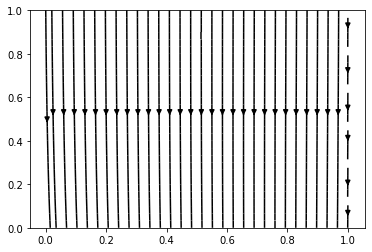

In [716]:
def visualize_vector_field(F):
    nb = 100
    t = 0.01
    y, x = np.mgrid[0.:1.:100j, 0.:1.:100j]
    stack_xy = np.stack([x, y], -1).reshape(nb * nb, 2)
    grid_xy = torch.Tensor(stack_xy)
    
    dudt = F(t, grid_xy).detach().numpy()
    mag = np.sqrt(dudt[:, 0]**2 + dudt[:, 1]**2).reshape(-1, 1) # Add 1 dimension at the end
    dudt = dudt / mag
    dudt = dudt.reshape(nb, nb, 2)
    plt.streamplot(x, y, dudt[:, :, 0], dudt[:, :, 1], color="black")
    
visualize_vector_field(f_model_2)

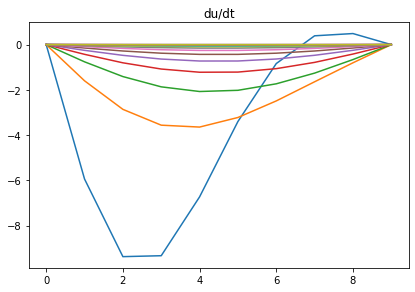

(100, 2)


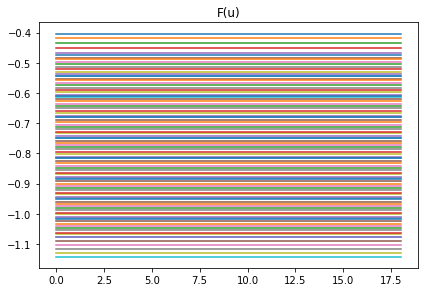

In [734]:
def visualize_F_with_u(F, t_n=5, x_n=10):
    g_u = get_heat_grad_t(1.0, 0.0, 1.0, 0.0, t_n, x_n)
    u_m = np.zeros((t_n, x_n * x_n, 2))
        
    t_range = np.linspace(0., 1., t_n)
    
    nb = x_n
    u, x = np.mgrid[0.:1.:10j, 0.:1.:10j]
    stack_xu = np.stack([x, u], -1).reshape(nb * nb, 2)
    grid_xu = torch.Tensor(stack_xu)
    t = torch.Tensor(t_range)
    
    for i in range(t_n):
        dudt = F(t[i], grid_xu).detach().numpy()
        u_m[i] = dudt
    
    simple_plotter(g_u[1:], 'du/dt')
    print(u_m[0].shape)
    simple_plotter([u_m[1:,:,1]], 'F(u)')

visualize_F_with_u(f_model_2, 20, 10)

In [718]:
def visualize_u_gu(t_n, x_n, t_idx=-1):
    u_true = get_heat(1.0, 0.0, 1.0, 0.0, t_n, x_n)
    g_u_true = get_heat_grad_t(1.0, 0.0, 1.0, 0.0, t_n, x_n)
    
    if t_idx != -1:
        u_true = [u_true[t_idx]]
        g_u_true = [g_u_true[t_idx]]
    
    simple_plotter(u_true, 'u')
    simple_plotter(g_u_true, 'du/dt')  

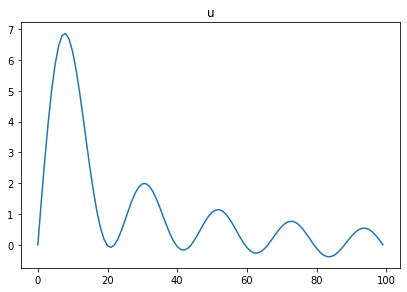

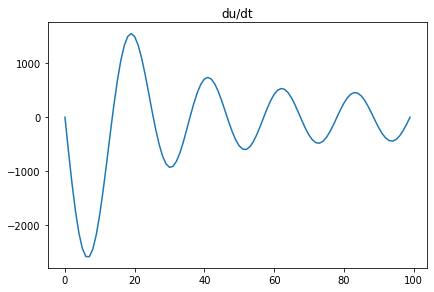

tensor([1.])


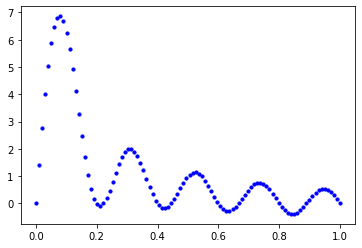

In [721]:
def visualize_u_from_F(F, t_n, x_n, t_idx=0):
    bt, b0, by = ode_data_processing(t_n, x_n, (0.0, 1.0), (0.0, 1.0), (1, x_n))
    t = bt[t_idx,:]
    print(t)
    u0 = b0[0]

    pred_u = odeint(F, u0, t).detach().numpy()
    
    for i in range(len(t)):
        for j in range(int(len(pred_u[i]))):
            zx = pred_u[i,j,0,0]
            zu = pred_u[i,j,0,1]
            plt.scatter(zx, zu, s=10, c='b')

visualize_u_gu(10, 100, 0)
visualize_u_from_F(f_model_2, 10, 100, 9)